[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tombackstrom/tombackstrom.github.io/HEAD?labpath=posts/informationbottleneck.ipynb)

### Thoughts and Theory, Notes on speech processing, 2.9.2021
# Information bottlenecks and dimensionality reduction in deep learning

Autoencoders and other deep neural networks with information bottlenecks have become fashionable. The heuristic idea is that the dimensionality of the hidden layers is reduced such that the network is forced to focus on the important part of the data. Experiments have also demonstrated that autoencoders are efficient in this sense. I have however been left wondering whether the amount of information can be characterized in exact terms. How much information flows through the bottleneck? How would we even measure that?

This short note is my attempt at characterizing and understanding the problem. I will start with some classical concepts of information theory and linear algebra and then discuss the extent to which such concepts are applicable in machine learning. A central result is that dimensionality of a hidden layer cannot alone be used as a measure of information content.

## Information content in discrete representations

If a system has two states, A and B, then obviously we can represent the state by one bit. Four states can be represented by 2 bits, 8 states by 3 bits and in general, $N$ states by $\log_2(N)$ bits. We can therefore always easily determine the number of bits required for systems with a finite number of states. The amount of bits needed to describe the state is then a direct measure of the information content or entropy of the system.

We can expand this to countable sets, such as integers, if we in additional have the access to probability of each state. Then we can make statements about average bitrate, that is, if we observe the system many times, how many bits do we on average need for representing the state? If the probability of state k is Pk, then the amount of bits needed to represent that state is $-\log_2 P_k$. That bitrate, $-\log_2 P_k$, occurs at probability $P_k$, such that the average bitrate can be calculated as the sum, $-\sum_k \log_2 P_k$, where the summation goes over all $k$. This applies also when $k$ goes over an infinite but countable set.


## Information content in linear, continuous valued systems

If the title is confusing, just think of linear algebra. How much information is there in a vector $x$ of length $N$. Well, it is not really defined. What we do however know is that if we multiply it with a matrix $A$, as $y=Ax$, then if the matrix $A$ is full rank, then all information is retained. In fact, then we can recover $x$ from $y$ by the inverse $x=A^{-1}y$. No information is lost. Clearly the rank of $A$ thus defines its capacity remove information. If $\textrm{rank}(A)<N$ then information is lost and cannot be recovered from $y$.

This is not yet the whole story though. In practical implementations of the inverse, we know that it is not only the rank which is important, but also the conditioning of $A$. If any of the singular values of $A$ are close to zero, then $A$ becomes ill-conditioned such that the recovery of $x$ from $y$ becomes numerically difficult. In the best case, we loose accuracy, such that $x$ can be recovered only approximately, in severe cases information can be entirely lost. The information content is thus not only described by dimensionality, but also characterized by accuracy. As we shall see, I argue that it is more useful to characterize loss of information as a loss of accuracy rather than loss of dimensions.

## Diversion: Space filling curves

If you have not heard about space-filling curves, start by watching the [Numberphile video](https://www.numberphile.com/videos/space-filling-curves) about them. The idea is an infinite recursion; you start with a simple shape which goes through a space. Then you add wiggles to that shape so that it spreads more over the space. Repeatedly adding more wiggles makes the curve spread out more and more, such that it converges to covering the whole space. The one-dimensional line thus covers the whole two-dimensional space (i.e. its [Hausdorff dimension](https://en.wikipedia.org/wiki/Hausdorff_dimension) is 2).

In terms of information content, now, the one-dimensional curve contains the information of the two-dimensional space. If we start with some particular point in 2D-space $(x,y)$, we can convert that to a point $d$ on the one-dimensional line, and then convert it back to the 2D-point $(x,y)$. It is just that there is an infinite recursion involved, so this is not a practical algorithm.

We can however, implement a finite number of recursions to get an approximation. In the example below, I have implemented an Hilbert-curve and plotted the curve for different number of recursions $N$.

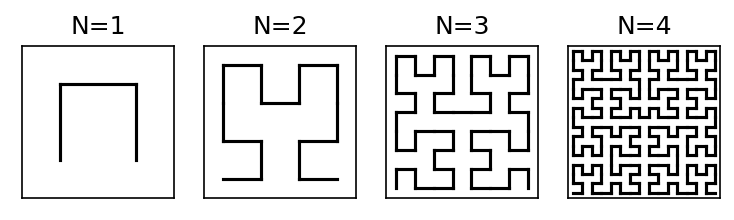

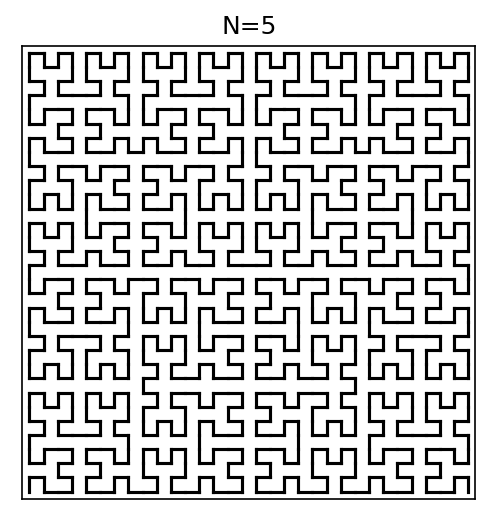

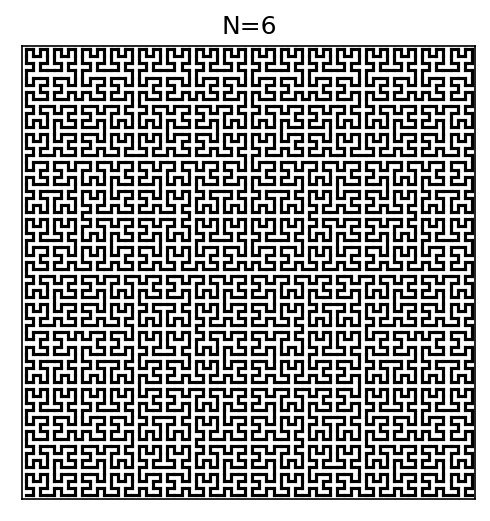

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def hilbert_curve_expansion(str, n):
    k = 0
    while k < len(str):
        if str[k] == 'A':
            str = str[0:k] + '+BF-AFA-FB+' + str[(k+1):]
            k+=10
        elif str[k] == 'B':
            str = str[0:k] + '-AF+BFB+FA-' + str[(k+1):]
            k+=10
        k += 1
    if n > 1:
        return hilbert_curve_expansion(str,n-1)
    else:
        return str

def draw_curve(str):
    direction = np.array([[1,0]])
    edge = np.zeros([2,2])+.5
    P = np.array([[0,1],[-1,0]])
    
    for c in str:
        if c == '+':
            direction = np.matmul(direction,P)
        elif c == '-':
            direction = np.matmul(direction,-P)
        elif c == 'F':
            edge[0,:] = edge[1,:]
            edge[1,:] = edge[1,:] + direction
            plt.plot(edge[:,0],edge[:,1],'k')
    

# plotting parameters
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*1.5

# plot hilbert curves with different number of recursions
for k in range(4):
    plt.subplot(241+k)
    curve = hilbert_curve_expansion('A',k+1)
    draw_curve(curve)
    plt.gca().set_aspect('equal', 'box')
    plt.xlim([0,2**(k+1)])
    plt.ylim([0,2**(k+1)])
    plt.xticks([])
    plt.yticks([])
    plt.title('N=' + str(k+1))

plt.show()

draw_curve(hilbert_curve_expansion('A',5))
plt.gca().set_aspect('equal', 'box')
plt.xlim([0,2**5])
plt.ylim([0,2**5])
plt.xticks([])
plt.yticks([])
plt.title('N=5')
plt.show()

draw_curve(hilbert_curve_expansion('A',6))
plt.gca().set_aspect('equal', 'box')
plt.xlim([0,2**6])
plt.ylim([0,2**6])
plt.xticks([])
plt.yticks([])
plt.title('N=6')
plt.show()

We can readily see that for each iteration, the accuracy with which the curve fills space is doubled (error is halved i.e. error energy is $1/4$th). By accuracy I refer to the average distance from a random point in 2D space to the closest point on the curve.

Each iteration, on the other hand, splits every segment into 4 sub-segments, at a cost of 2 bits. Halving the error thus comes at a cost of 2 bits. This results thus follows results of conventional lossy coding; halving error costs as many bits as we have dimensions. Now we have 2 dimensions so halving error costs 2 bits.


## Information content in autoencoders

Observe that the above space-filling curve construction can be interpreted as an autoencoder. The 2-dimensional space is mapped (encoder) to a 1 dimensional space (bottleneck), which we can recover with the inverse (decoder). The curve is piecewise linear and could easily be implemented with a single layer of rectified linear units (RELUs). Each recursion consists of a subdivision into 4 parts, such that we can expect that the network can be implemented with $2^{2N}$ RELUs. Conversely, the error of the mapping is halved if the number of RELUs is quadrupled.


## A red herring

One could easily be fooled to think that we can do some simpler space filling curve than Hilbert (or other equivalent curves). For example, we could draw zig-zag lines going end-to-end on dimension $x$ and then takes a step $1/N$ on dimension $y$. This can be implemented with $O(N)$ RELUs. The accuracy of this map would then be relative to $2^{-N}$ instead of $2^{-2N}$. However, we would then have error only on the y dimension and the x dimension could be always perfectly reconstructed. Our accuracy argument thus applies as before, we need 1 bit for each dimension to halve accuracy, when assuming that accuracy on each axis is equal.


## Reconstruction accuracy as a measure of information

The pertinent consequence for autoencoders is that the dimensionality of the bottleneck does not alone define the amount of information that passes through. By exponentially increasing the number of non-linearities in the encoder and decoder, we gain a log-linear decrease in mean square error. Since we thus cannot measure information with the number of dimensions, we should therefore rather measure the amount of information in terms of reconstruction accuracy.

This approach is in line also with conventional concepts in probability and statistics. For continuous valued variables $x$, we cannot define a probability, but only probability distributions, since there are an infinite number of possible values and any particular value would always have probability zero. In a similar fashion, for continuous-valued information bottlenecks, we cannot define absolute information content, but only relative information content, in terms of accuracy. That is, we can say that accuracy (and thus information content) is improved or reduced when changing the network structure, in particular with respect to the number of non-linearities. We can however not say how much information is passed through, but only compare relative amounts of information with different network structures.

## Vector quantization

A particular form of autoencoders which have become fashionable is the VQ-VAE, or vector quantized variational autoencoder. I won’t be going into the ‘variational’ part here, but the vector quantized autoencoder refers to systems where the bottleneck is also quantized. In particular, vector quantizers have a fixed number of quantization levels such that the bitrate is well-defined. The above analysis is thus not directly applicable to such systems. Heuristically, I would argue (and guess) that the encoder complexity has to be sufficient, such that it can digest information into a form which the VQ can handle. Increasing the encoder complexity further would not improve reconstruction accuracy, since it is limited by the VQ accuracy. Conversely, if the encoder has a given structure, then the VQ bitrate has to be sufficient such that it can take full benefit of the embedding. From the space-filling curves above, you can appreciate that if the VQ bitrate is low, then it cannot model the complicated information contained in the high-recursion curves. In other words, the encoder structure and the VQ bitrate have to be jointly matched for optimal performance.

## Conclusion and to-do’s


This is was my first, quick-and-dirty attempt of characterizing the information content in autoencoders. My own impression is that I’m on to something. Clearly a complex encoder can compress information into a narrow bottleneck such that it can be reconstructed with high accuracy. In fact, assuming perfect accuracy (no numerical round-off errors), then any vector could be compressed to a single real value and reconstructed with arbitrary accuracy, if the corresponding encoder and decoder are sufficiently complex. The magic is in the way the space-filling curve embeds infinities; two infinitely accurate signals can be interleaved together without loss of information.

The above presentation does not have rigorous proofs and there’s plenty of hand-waving involved. For example, I detailed only the case where a 2D signal is mapped to a 1D signal (2D-to-1D), it can be easily extended to ND-to-1D, but a bit more reflection is needed to extend it to arbitrary width bottlenecks, ND-to-KD. I also did not properly define reconstruction accuracy, nor the number of RELUs in a space-filling curve and so on. I further would like to actually implement the space filling curve with something like pytorch as a demonstration. The VQ discussion was also superficial. I also haven’t done a literature study; let me know if you know of related work! Perhaps next time.

In any case, this is a start for a theoretical discussion about information content in autoencoders and related deep neural networks.